# Studying the performance on the UTI dataset with the context of the label collection time

In [22]:
import os
import json
import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import load_nested_dict_to_pandas

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [23]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [24]:
RESULTS_PATH = Path(os.path.join("results", "elicitation"))

In [25]:
number_of_labels_to_plot = [5, 10, 20, 30, 40, 50]

Loading results

In [26]:
def load_result_dicts(path: Path):
    results_files = [
        f for f in os.listdir(path) 
        if (f.endswith(".json") and f.startswith("prior_no_prior"))
    ]
    print(f"Loading {len(results_files)} files from {path}")
    results_dicts = [
        json.load(open(os.path.join(path, f), "r"))
        for f in results_files
    ]

    return results_files, results_dicts

In [27]:
def result_dicts_to_df(results_files, results_dicts):
    results_dfs = [
        load_nested_dict_to_pandas(
            results_dict, level_names=["dataset", "run", "n_data_points_seen", "prior_type"]
        ).assign(results_file_name=results_file_name)
        
        for results_dict, results_file_name in zip(results_dicts, results_files)
    ]

    results_df = pd.concat(
        results_dfs
    ).astype(
        {
            "n_data_points_seen": int,
        }
    )

    return results_df

In [28]:
# results directory for each model
model_results_dir_dict = {
    "gpt_prior": "gpt-3-5-turbo-0125",
    "uninformative": "uninformative",
    "gpt_4_turbo_prior": "gpt-4-turbo-2024-04-09",
    "deepseek_32b_q4": "deepseek-r1-32b-int4",
}

results_df = pd.DataFrame()

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    results_df = pd.concat(
        [
            results_df,
            # loading the results from the dictionaries to a dataframe
            result_dicts_to_df(
                # loading the files to dictionaries
                *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
            ).replace(
                # adding the model name
                {"prior_type": {"informative": model_name}}
            )
        ]
    )

Loading results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading 80 files from results/elicitation/gpt-3-5-turbo-0125


Loading results:  25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

Loading 80 files from results/elicitation/uninformative


Loading results:  50%|█████     | 2/4 [00:07<00:07,  3.82s/it]

Loading 80 files from results/elicitation/gpt-4-turbo-2024-04-09


Loading results:  75%|███████▌  | 3/4 [00:11<00:03,  3.66s/it]

Loading 60 files from results/elicitation/deepseek-r1-32b-int4


Loading results: 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]


In [29]:
results_df = results_df.query("dataset == 'uti'")

Processing the results

In [30]:
dataset_metric_to_plot = {
    "uti": "accuracy",
}
dataset_rename = {
    "uti": "UTI",
}


accuracy_results = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(sample=lambda x: x["metrics_to_plot"].apply(lambda x: np.arange(len(x))))
    .explode(["metrics_to_plot", "sample"])
    .set_index("sample", append=True)
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
)
accuracy_results

,dataset,n_data_points_seen,prior_type,run,sample,metrics_to_plot
0,UTI,2,gpt_prior,9,0,0.533679
1,UTI,2,gpt_prior,9,1,0.569948
2,UTI,2,gpt_prior,9,2,0.564767
3,UTI,2,gpt_prior,9,3,0.492228
4,UTI,2,gpt_prior,9,4,0.471503
...,...,...,...,...,...,...
6999995,UTI,50,deepseek_32b_q4,6,24995,0.716049
6999996,UTI,50,deepseek_32b_q4,6,24996,0.62963
6999997,UTI,50,deepseek_32b_q4,6,24997,0.623457
6999998,UTI,50,deepseek_32b_q4,6,24998,0.561728


In [31]:
dataset_metric_to_plot = {
    "uti": "average_auc",
}

dataset_rename = {
    "uti": "UTI",
}


auc_results = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(sample=lambda x: x["metrics_to_plot"].apply(lambda x: np.arange(len(x))))
    .explode(["metrics_to_plot", "sample"])
    .set_index("sample", append=True)
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
)
auc_results

,dataset,n_data_points_seen,prior_type,run,sample,metrics_to_plot
0,UTI,2,gpt_prior,9,0,0.615836
1,UTI,5,gpt_prior,9,0,0.781671
2,UTI,10,gpt_prior,9,0,0.740431
3,UTI,20,gpt_prior,9,0,0.761725
4,UTI,30,gpt_prior,9,0,0.772642
...,...,...,...,...,...,...
275,UTI,10,deepseek_32b_q4,6,0,0.745431
276,UTI,20,deepseek_32b_q4,6,0,0.772844
277,UTI,30,deepseek_32b_q4,6,0,0.767727
278,UTI,40,deepseek_32b_q4,6,0,0.690424


In [32]:
accuracy_results_line_plot = (
    accuracy_results
    .loc[lambda df: df["n_data_points_seen"].isin(number_of_labels_to_plot)]
    .groupby(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .mean()
    .reset_index()
)

In [33]:
auc_results_line_plot = (
    auc_results
    .loc[lambda df: df["n_data_points_seen"].isin(number_of_labels_to_plot)]
    .groupby(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .mean()
    .reset_index()
)

Loading the original labels

In [34]:
labels_path = Path.home().joinpath("data/version_1_uti_labels.parquet")
labels = pd.read_parquet(labels_path)

In [35]:
labels = (
    labels
    .assign(
        days_since_first_label=
            lambda df: (
                (df["date"] - df["date"].min()).dt.days
            )
    )
    .drop(columns=["date"])
)

In [36]:
labels_cumulative_by_outcome = (
    labels
    .astype({"outcome": int})
    .assign(count=1)
    .groupby(["outcome", "days_since_first_label" ])
    [["count"]]
    .sum()
    .groupby("outcome")
    .cumsum()
    .reset_index()
)

labels_cumulative = (
    labels
    .assign(count=1)
    .groupby("days_since_first_label")
    [["count"]]
    .sum()
    .cumsum()
    .reset_index()
)

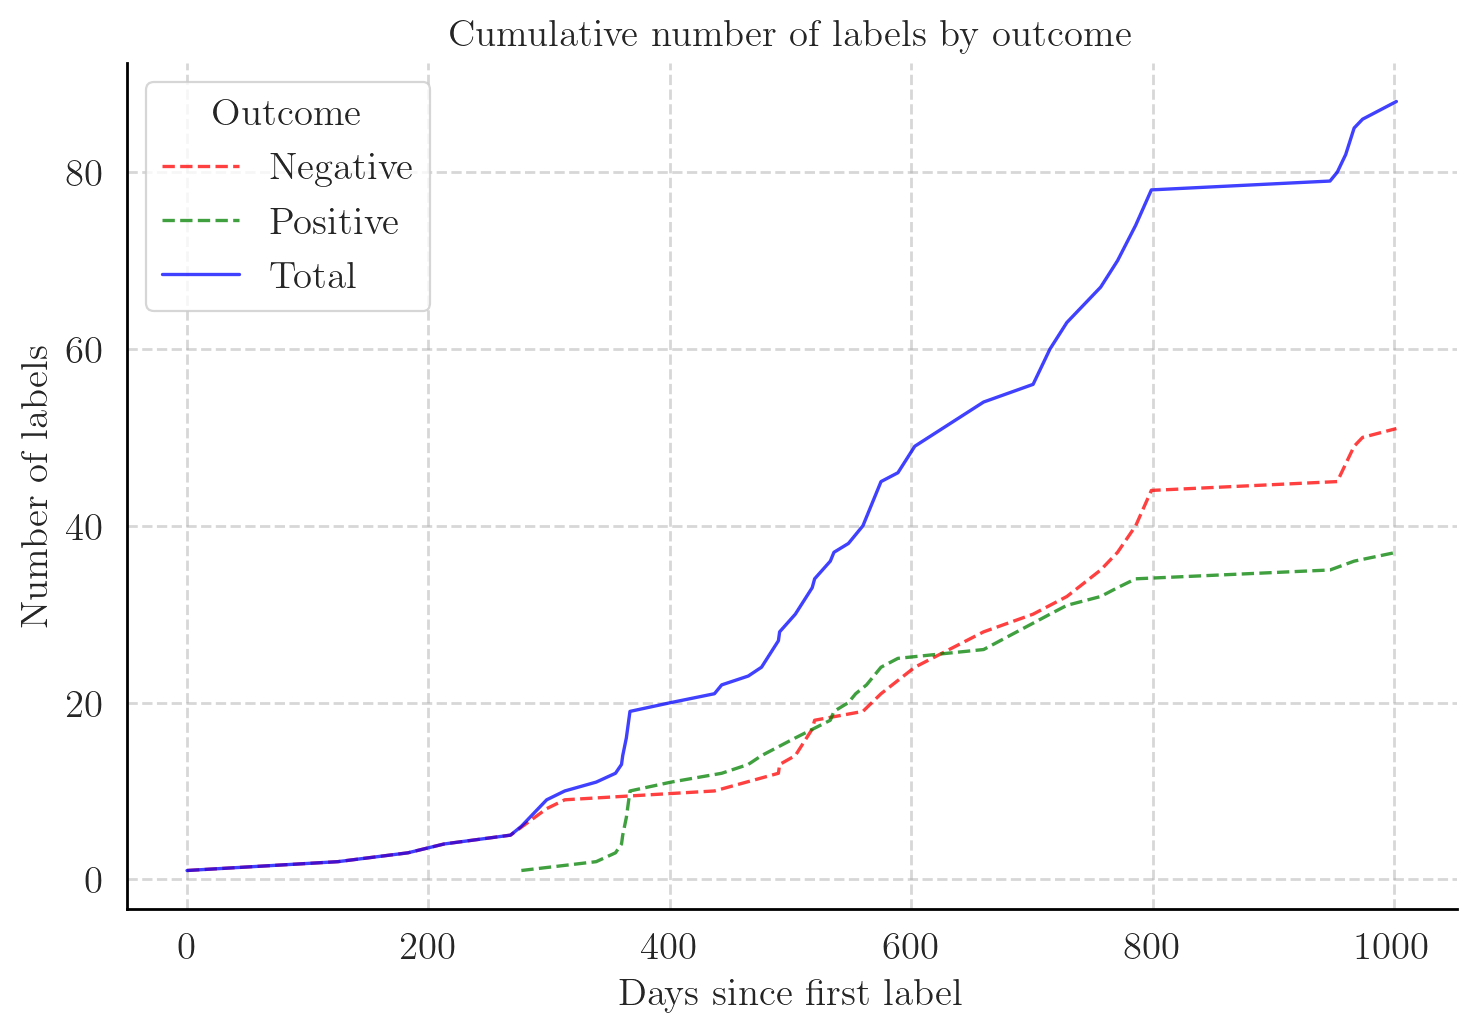

In [37]:
fontsize = 14

with graph_theme():
    plt.close()

    fig, ax = plt.subplots(
        1, 1, 
        figsize=(2.5*colwidth, 2*0.8*colwidth)
    )

    sns.lineplot(
        data=labels_cumulative_by_outcome.replace(
            {"outcome": {0: "Negative", 1: "Positive"}}
        ),
        x="days_since_first_label",
        y="count",
        hue="outcome",
        palette=["red", "green"],
        linestyle="--",
        ax=ax,
        alpha=0.75,
    )


    sns.lineplot(
        data=labels_cumulative,
        x="days_since_first_label",
        y="count",  
        ax=ax,
        color="blue",
        label="Total",
        alpha=0.75,
    )

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel("Days since first label", fontsize=fontsize)
    ax.set_ylabel("Number of labels", fontsize=fontsize)
    ax.set_title("Cumulative number of labels by outcome", fontsize=fontsize)
    ax.legend(title="Outcome", fontsize=fontsize, title_fontsize=fontsize)

    fig.savefig("results/labels_cumulative_by_outcome.pdf", bbox_inches="tight")
    fig.savefig("results/labels_cumulative_by_outcome.svg", bbox_inches="tight")


    plt.show()

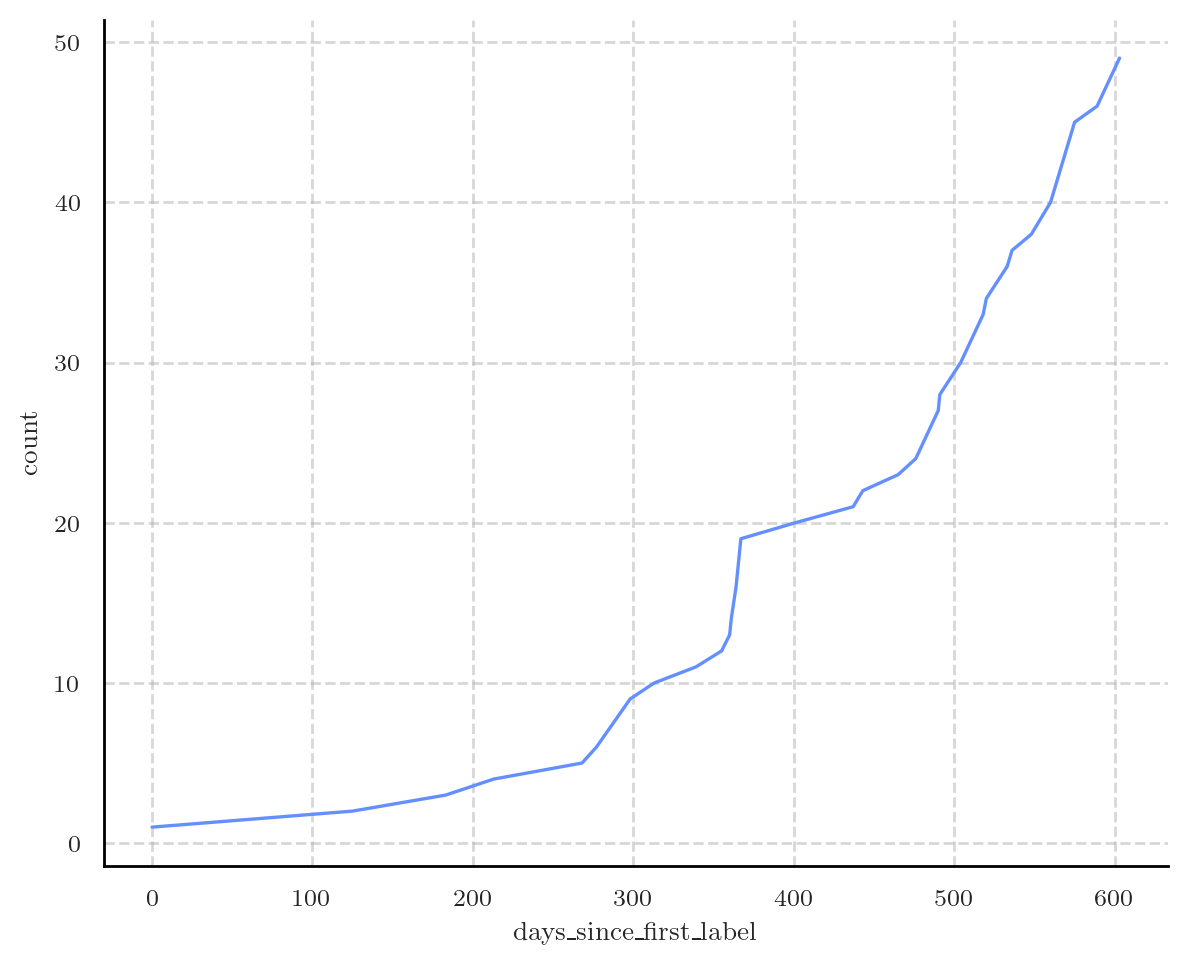

In [38]:
with graph_theme():
    plt.close()

    fig, ax = plt.subplots(
        1, 1, 
        figsize=(2*colwidth, 2*0.8*colwidth)
    )

    sns.lineplot(
        data=labels_cumulative.loc[lambda df: df["count"] <= 50],
        x="days_since_first_label",
        y="count",
        ax=ax,
    )

    plt.show()

In [39]:
days_to_plot = np.interp(
    number_of_labels_to_plot,
    labels_cumulative["count"],
    labels_cumulative["days_since_first_label"],
).round(0).astype(int)

In [40]:
accuracy_results_line_plot = accuracy_results_line_plot.assign(
    n_days = lambda df: df["n_data_points_seen"].map(
        dict(zip(number_of_labels_to_plot, days_to_plot))
    )
)

auc_results_line_plot = auc_results_line_plot.assign(
    n_days = lambda df: df["n_data_points_seen"].map(
        dict(zip(number_of_labels_to_plot, days_to_plot))
    )
)

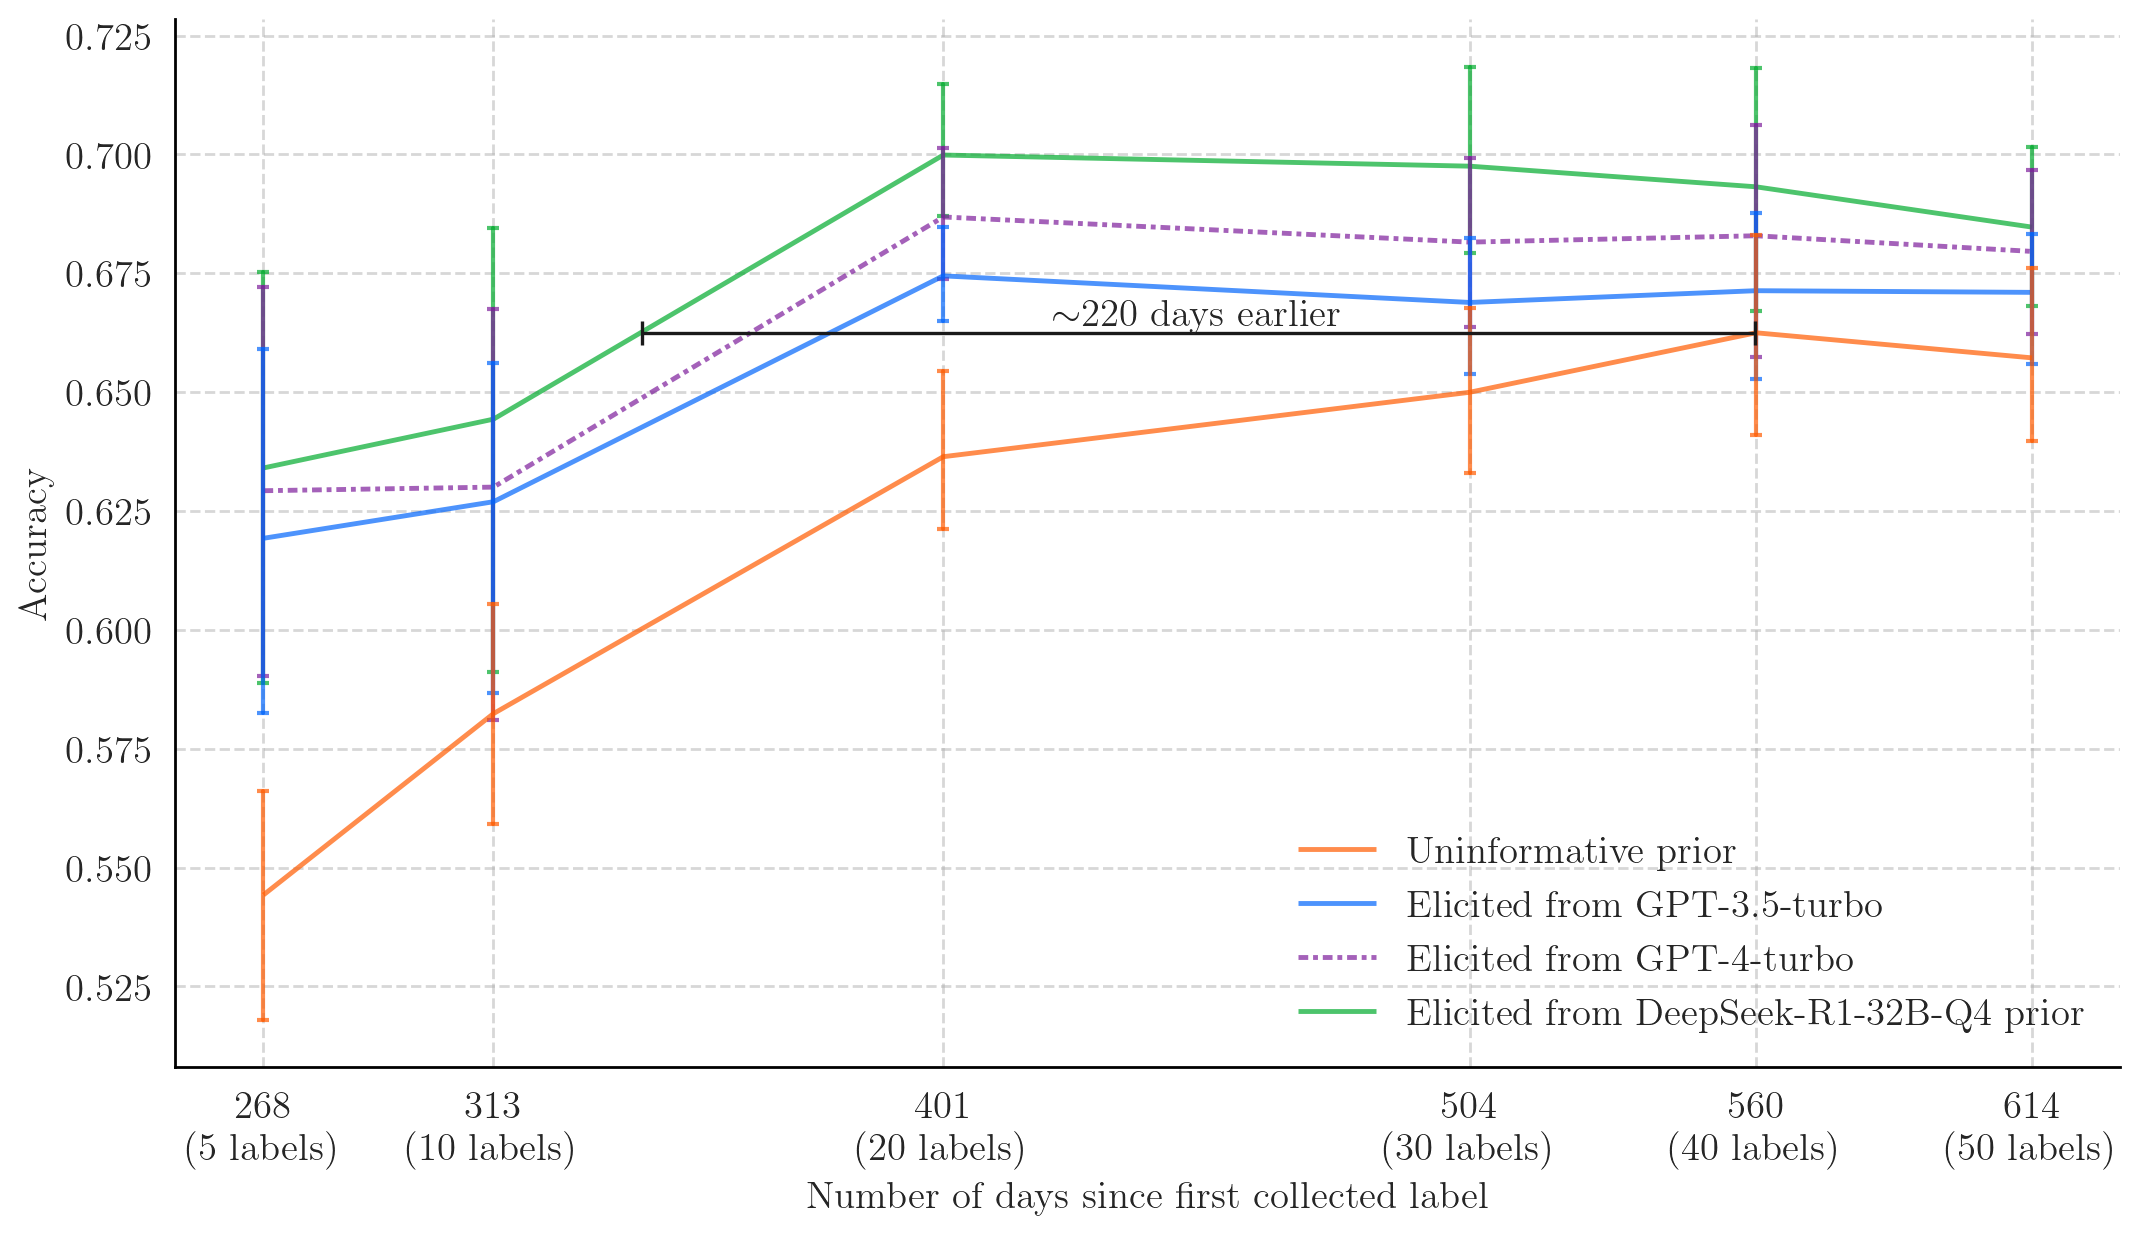

In [41]:
methods_to_plot = [
    "uninformative",
    "gpt_prior",
    "gpt_4_turbo_prior",
    "deepseek_32b_q4",
    
]

method_names = {
    "uninformative": "Uninformative prior", 
    "gpt_prior": "Elicited from GPT-3.5-turbo",
    "gpt_4_turbo_prior": "Elicited from GPT-4-turbo",
    "deepseek_32b_q4": r"Elicited from DeepSeek-R1-32B-Q4 prior",
}

palette = {
    method_names["uninformative"]: "xkcd:bright orange",
    method_names["gpt_prior"]: "xkcd:bright blue",
    method_names["gpt_4_turbo_prior"]: "xkcd:purple",
    method_names["deepseek_32b_q4"]: "xkcd:kelly green",
}

markers = {
    method_names["uninformative"]: "o",
    method_names["gpt_prior"]: "X",
    method_names["gpt_4_turbo_prior"]: "P",
    method_names["deepseek_32b_q4"]: "s",
}

dashes = {
    method_names["uninformative"]: (1, 0), #(2, 1, 1, 1),
    method_names["gpt_prior"]: (1, 0), #(4,1,),
    method_names["gpt_4_turbo_prior"]: (2,1,1,1),
    method_names["deepseek_32b_q4"]: (1, 0),
}

linewidth_on_plot = 1.75
alpha = 0.7

fontsize=14


dataset = "UTI"

with graph_theme():
    plt.close()

    fig, ax = plt.subplots(
        1, 1, 
        figsize=(1.5*linewidth, 0.7*2*linewidth/1.618)
    )

    ax = sns.lineplot(
        data=(
            accuracy_results_line_plot
            .query("dataset == @dataset")
            .replace({"prior_type": method_names})
        ),
        x="n_days",
        y="metrics_to_plot",
        hue="prior_type",
        palette=palette,
        style="prior_type",
        style_order=[
            method_names[m_name]
            for m_name in methods_to_plot
        ],
        alpha=0.7,
        dashes=dashes,
        err_style="bars",
        errorbar=("ci", 95),
        err_kws=dict(
            capsize=2,
            capthick=1.5,
            elinewidth=1.5,
            linewidth=1.5,
        ),
        markersize=6,
        linewidth=linewidth_on_plot,
        ax=ax,
        legend=False
    )

    ax.set_ylabel("Accuracy", fontsize=fontsize)
    ax.set_xlabel("Number of days since first collected label", fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_title("", fontsize=fontsize)
    ax.set_xticks(days_to_plot)
    ax.set_xticklabels(
        [f"{d}\n ({n} labels)" for d, n in zip(days_to_plot, number_of_labels_to_plot)],
        fontsize=fontsize,
    )

    accuracy_by_method = (
        accuracy_results_line_plot
        .query("dataset == @dataset")
        .groupby(["prior_type", "n_days"])
        ["metrics_to_plot"]
        .mean()
    )

    accuracy_informative = accuracy_by_method.loc["deepseek_32b_q4"].values.astype(float)
    accuracy_uninformative = accuracy_by_method.loc["uninformative"].values.astype(float)
    n_days_for_bar = np.array(accuracy_by_method.loc["deepseek_32b_q4"].index)

    n_days_for_bar_informative_interpolated = np.interp(
        accuracy_uninformative,
        accuracy_informative,
        n_days_for_bar,
    )

    for y, xmin, xmax in zip(
        accuracy_uninformative[-2:-1], 
        n_days_for_bar_informative_interpolated[-2:-1], 
        n_days_for_bar[-2:-1]
    ):
        ax.hlines(
            y,
            xmin+0.25, xmax-0.25, 
            color="k",
            alpha=1
        )
        ax.vlines(
            xmin+0.25,
            ymin=y-0.0025, ymax=y+0.0025,
            color="k",
            alpha=1
        )
        ax.vlines(
            xmax-0.25,
            ymin=y-0.0025, ymax=y+0.0025,
            color="k",
            alpha=1
        )


    ax.text(
        x = (xmax + xmin)/2,
        y = y,
        s = r"$\sim$" + f"{round(xmax - xmin, -1):.0f} days earlier",
        fontsize=fontsize,
        ha="center",
        va="bottom",
    )

    leg = ax.legend(
        loc="lower right",
        labels=[
            method_names[m_name] for m_name in methods_to_plot
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[method_names[m_name]], 
                markerfacecolor=palette[method_names[m_name]], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                linestyle=(0, dashes[method_names[m_name]]),
                alpha=alpha,
            )
            for m_name in methods_to_plot
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        frameon=False,
    )

    fig.subplots_adjust(
        wspace=0.35,
        left=0.08,
        right=0.99,
        top=0.98,
        bottom=0.13,
    )

    fig.savefig("results/elicitation_results_lineplot_uti_with_dates.pdf")
    fig.savefig("results/elicitation_results_lineplot_uti_with_dates.png", dpi=300)
    fig.savefig("results/elicitation_results_lineplot_uti_with_dates.svg")

    plt.show()

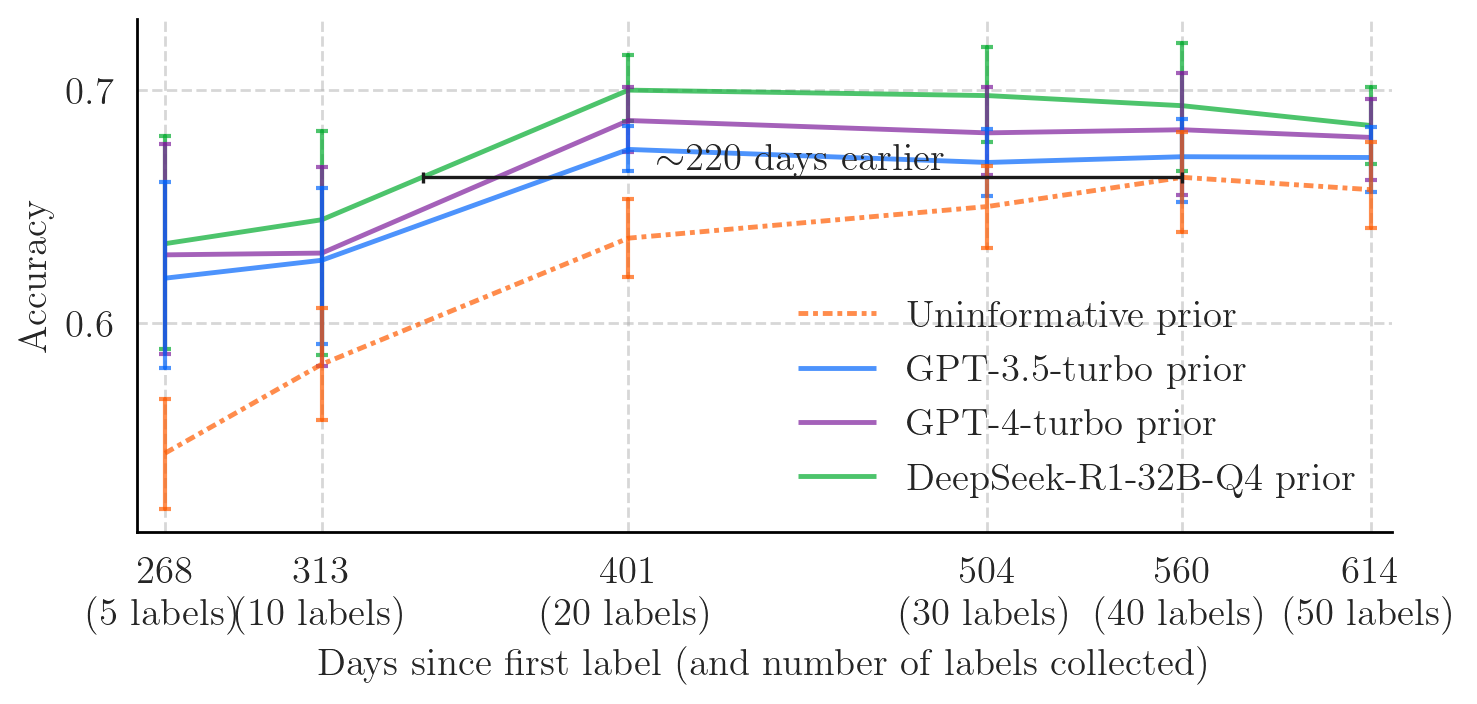

In [42]:
methods_to_plot = [
    "uninformative",
    "gpt_prior",
    "gpt_4_turbo_prior",
    "deepseek_32b_q4",
]

method_names = {
    "uninformative": "Uninformative prior", 
    "gpt_prior": r"GPT-3.5-turbo prior", 
    "gpt_4_turbo_prior": r"GPT-4-turbo prior", 
    "deepseek_32b_q4": r"DeepSeek-R1-32B-Q4 prior",
    
}

palette = {
    method_names["uninformative"]: "xkcd:bright orange",
    method_names["gpt_prior"]: "xkcd:bright blue",
    method_names["gpt_4_turbo_prior"]: "xkcd:purple",
    method_names["deepseek_32b_q4"]: "xkcd:kelly green",
}

markers = {
    method_names["uninformative"]: "o",
    method_names["gpt_prior"]: "X",
    method_names["gpt_4_turbo_prior"]: "P",
    method_names["deepseek_32b_q4"]: "s",
}

dashes = {
    method_names["uninformative"]: (2,1,1,1),
    method_names["gpt_prior"]: (1, 0), 
    method_names["gpt_4_turbo_prior"]: (1, 0), 
    method_names["deepseek_32b_q4"]: (1, 0),
}

linewidth_on_plot = 1.75
alpha = 0.7

fontsize=14


dataset = "UTI"

with graph_theme():
    plt.close()

    fig, ax = plt.subplots(
        1, 1, 
        figsize=(2.1*colwidth, 0.8*2*colwidth/1.618)
    )

    ax = sns.lineplot(
        data=(
            accuracy_results_line_plot
            .query("dataset == @dataset")
            .replace({"prior_type": method_names})
        ),
        x="n_days",
        y="metrics_to_plot",
        hue="prior_type",
        palette=palette,
        style="prior_type",
        style_order=[
            method_names[m_name]
            for m_name in methods_to_plot
        ],
        alpha=0.7,
        dashes=dashes,
        err_style="bars",
        errorbar=("ci", 95),
        err_kws=dict(
            capsize=2,
            capthick=1.5,
            elinewidth=1.5,
            linewidth=1.5,
        ),
        markersize=6,
        linewidth=linewidth_on_plot,
        ax=ax,
        legend=False
    )

    ax.set_xlim(260, 620)

    ax.set_ylabel("Accuracy", fontsize=fontsize)
    ax.set_xlabel(
        "Days since first label (and number of labels collected)", 
        fontsize=fontsize
    )
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_title("", fontsize=fontsize)
    ax.set_xticks(days_to_plot)
    ax.set_xticklabels(
        [
            f"{d}\n ({n} labels)" 
            for d, n in zip(days_to_plot, number_of_labels_to_plot)
        ],
        fontsize=fontsize,
    )
    ax.set_yticks(np.arange(0.5, 1.01, 0.1))

    accuracy_by_method = (
        accuracy_results_line_plot
        .query("dataset == @dataset")
        .groupby(["prior_type", "n_days"])
        ["metrics_to_plot"]
        .mean()
    )

    accuracy_informative = accuracy_by_method.loc["deepseek_32b_q4"].values.astype(float)
    accuracy_uninformative = accuracy_by_method.loc["uninformative"].values.astype(float)
    n_days_for_bar = np.array(accuracy_by_method.loc["deepseek_32b_q4"].index)

    n_days_for_bar_informative_interpolated = np.interp(
        accuracy_uninformative,
        accuracy_informative,
        n_days_for_bar,
    )

    for y, xmin, xmax in zip(
        accuracy_uninformative[-2:-1], 
        n_days_for_bar_informative_interpolated[-2:-1], 
        n_days_for_bar[-2:-1]
    ):
        ax.hlines(
            y,
            xmin+0.25, xmax-0.25, 
            color="k",
            alpha=1
        )
        ax.vlines(
            xmin+0.25,
            ymin=y-0.0025, ymax=y+0.0025,
            color="k",
            alpha=1
        )
        ax.vlines(
            xmax-0.25,
            ymin=y-0.0025, ymax=y+0.0025,
            color="k",
            alpha=1
        )


    ax.text(
        x = (xmax + xmin)/2,
        y = y,
        s = r"$\sim$" + f"{round(xmax - xmin, -1):.0f} days earlier",
        fontsize=fontsize,
        ha="center",
        va="bottom",
    )

    leg = ax.legend(
        loc="lower right",
        labels=[
            method_names[m_name] for m_name in methods_to_plot
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[method_names[m_name]], 
                markerfacecolor=palette[method_names[m_name]], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                linestyle=(0, dashes[method_names[m_name]]),
                alpha=alpha,
            )
            for m_name in methods_to_plot
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        frameon=False,
    )

    fig.subplots_adjust(
        wspace=0.35,
        left=0.085,
        right=0.955,
        top=0.98,
        bottom=0.225,
    )

    fig.savefig("results/elicitation_results_lineplot_uti_with_dates_single_col.pdf")
    fig.savefig("results/elicitation_results_lineplot_uti_with_dates_single_col.png", dpi=300)
    fig.savefig("results/elicitation_results_lineplot_uti_with_dates_single_col.svg")

    plt.show()